Weak lensing calculation tests
------------------------------

This notebook shows some weak lensing tests: how the reduced shear can be obtained from
measuring background galaxy ellipticities.

In [17]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.images as images
from grale.constants import *
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

V = lambda x,y: np.array([x,y], dtype=np.double)
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
D = cosm.getAngularDiameterDistance

feedback.setDefaultFeedback("none")

We'll work with a lens model that I've used for strong lensing tests, just to have some
model to work with.

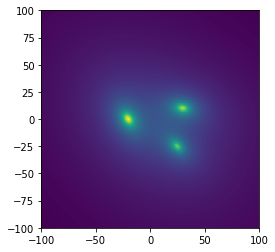

In [2]:
z_lens = 0.4
lens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
Dd = D(z_lens)

li = plotutil.LensInfo(lens, size=200*ANGLE_ARCSEC, zd=z_lens, cosmology=cosm)
plotutil.plotDensity(li, angularUnit=ANGLE_ARCSEC);

A linear approximation of the lens equation

$$ \vec{\beta}(\vec{\theta}) = \vec{\theta} - \vec{\alpha}(\vec{\theta})$$

around a certain $\vec{\theta}$ and corresponding $\vec{\beta}(\vec{\theta})$ can be written in
matrix form as

$$\left(\begin{array}{c} \Delta\beta_x \\ \Delta\beta_y \end{array} \right) 
\left(\begin{array}{cc} 1-\kappa-\gamma_1 & -\gamma_2 \\ -\gamma_2 & 1-\kappa+\gamma_1 \end{array} \right) 
\left(\begin{array}{c} \Delta\theta_x \\ \Delta\theta_y \end{array} \right) 
$$
This matrix has eigenvalues $1-\kappa-\gamma$ and $1-\kappa+\gamma$, where $\gamma = \sqrt{\gamma_1^2 + \gamma_2^2}$, and corresponding eigenvectors $(\gamma_2, \gamma-\gamma_1)$ and $(\gamma_1-\gamma, \gamma_2)$ respectively. Calling $\phi$ the angle between the line through the the first eigenvector and the $x$ axis, one finds
$$ \gamma_1 = \gamma\cos(2\phi)$$
$$ \gamma_2 = \gamma\sin(2\phi)$$

In a first test, we'll work with a circular source, which will be transformed into an ellipse because of the
transformation above (which is from image plane to source plane, so actually using the inverse transformation). From image plane to source plane, along the axes of the eigenvectors (which are orthogonal), the shape is scaled by $1-\kappa+\gamma$ and $1-\kappa-\gamma$. 

If we go from source plane to lens plane, the eigenvectors will be the same, but the scaling will be the inverse. So a circular source of radius $R$ will be transformed into an ellipse with axes $a = \frac{R}{1-\kappa-\gamma}$ and $b = \frac{R}{1-\kappa+\gamma}$. The ratio of the two is

$$\frac{b}{a} = \frac{1-\kappa-\gamma}{1-\kappa+\gamma} = \frac{1-g}{1+g}$$

where the reduced shear

$$g = \frac{\gamma}{1-\kappa}$$

was introduced. This can be rearranged to get the reduced shear from the axes of the ellipse:

$$g = \frac{1-\frac{b}{a}}{1+\frac{b}{a}}$$

The angle $\phi$ can be derived from the angle that the ellipse makes with the $x$-axis. For a list of vectors, assumed to describe an elliptical shape, the function `estimageAngleAndAxes`below returns this angle, together with the lengths of the long and short axes.

When estimating $a$ and $b$ from the elliptic shape, the resulting quantities will of course be positive. Note that when stating that e.g.  $a = \frac{R}{1-\kappa-\gamma}$, it's possible that this value will actually be negative, and so will differ from the value estimated from the shape. Even worse, based on the eigenvalues themselves, it's not necessarily the case that $1-\kappa-\gamma$ has the smallest absolute value, which would mean that the roles of $a$ and $b$ are actually reversed. These considerations lead to the possibility that for measured (positive) values of $a$ and $b$, where $a > b$, that the correct estimate of $g$ would be the inverse of the formula above:

$$g = \frac{1+\frac{b}{a}}{1-\frac{b}{a}}$$

Of course, solely based on the observed shape of the ellipse, there's no way to know which is actually correct. If we're assuming to be in the weak-lensing regime, where the mass density $\kappa$ is small and shear is small, then the first formula will be the one to use.

In [3]:
def estimateAngleAndAxes(thetas):
    center = np.mean(thetas, axis=0)
    dist = np.sum((thetas-center)**2,1)**0.5
    
    longIdx = np.argmax(dist)
    shortIdx = np.argmin(dist)

    dthetas = thetas-center
    angle = np.arctan2(dthetas[longIdx][1], dthetas[longIdx][0])
    
    plt.plot([center[0], thetas[longIdx][0]], [center[1], thetas[longIdx][1]], label="Long axis estimation", linewidth=3)
    plt.plot([center[0], thetas[shortIdx][0]], [center[1], thetas[shortIdx][1]], label="Short axis estimation", linewidth=3)
    plt.plot([center[0]], [center[1]], 'o', label="Center estimation")
                                              
    return angle, dist[longIdx], dist[shortIdx]

The helper function `getWeakLensingProperties` returns various properties like $\gamma$ or the eigenvectors at a specific point in the image plane, for the specified gravitational lens model:

In [4]:
def getWeakLensingProperties(lens, theta, zs, targetLength=0.05):
    axx, ayy, axy = lens.getAlphaVectorDerivatives(theta)
    frac = D(z_lens,zs)/D(zs)
    axx *= frac
    ayy *= frac
    axy *= frac
    kappa = 0.5*(axx+ayy)
    gamma1 = 0.5*(axx-ayy)
    gamma2 = axy
    gamma = (gamma1**2 + gamma2**2)**0.5
        
    lambda1 = 1-kappa-gamma
    lambda2 = 1-kappa+gamma
    
    def changeLength(xy, targetLength):
        currentLength = (xy[0]**2 + xy[1]**2)**0.5
        return xy * targetLength/currentLength
    
    v1 = changeLength(V(gamma2, gamma-gamma1), targetLength)
    v2 = changeLength(V(gamma1-gamma, gamma2), targetLength)

    return kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2

The helper function `pickBetaTheta` will choose a point $\vec{\beta}$ in the source plane, a redshift of the source, and will calculate the corresponding point $\vec{\theta}$ in the image plane. The helper function `generateBetaCircleAndTrace` will create a list of points that describe a circle centered on the location $\vec{\beta}$ in the source plane, and for each of these points a corresponding point in the image plane will be calculated. This way, we get a circular shape in the source plane, and get to see the corresponding shape in the image plane (which will be an ellipse if the linear approximation holds).

In [5]:
def pickBetaTheta(beta=None, theta=None, zs=None):
    betaOrig = beta
    zsOrig = zs
    while True:
        beta = np.random.uniform(-30*ANGLE_ARCSEC, 30*ANGLE_ARCSEC, 2) if betaOrig is None else betaOrig
        zs = np.random.uniform(1.5,4) if zsOrig is None else zsOrig

        if theta is None:
            li.setSourceRedshift(zs)
            ip = li.getImagePlane()
            trace = ip.traceBeta(beta)
            if len(trace) > 0:
                theta = trace[0]
                break
            else:
                if betaOrig is not None:
                    raise Exception("Using beta that can't be traced")
                #print("Retrying...")
        else:
            break
            
    return beta, theta, zs

def generateBetaCircleAndTrace(beta, betaRadius, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))
    betas[:,0] = betaRadius*np.cos(angles) + beta[0]
    betas[:,1] = betaRadius*np.sin(angles) + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

The function `estimateReducedShearFromDeformedCircularSource` will do a small first test: it creates a circular source at a random location and calculates the corresponding shape in the image plane. From this shape, the angle it makes with the $x$-axis and the long and short ellipse axes are estimated and using the formulas above the reduced shear and it's components are estimated. The true values, directly from the lens model are shown as well for comparison.

In [6]:
def estimateReducedShearFromDeformedCircularSource():
    
    def plotVector(v, *args, **kwargs):
        plt.plot([0, v[0]], [0, v[1]], *args, **kwargs)
    
    beta, theta, zs = pickBetaTheta()
    betaArcsec = beta/ANGLE_ARCSEC
    thetaArcsec = theta/ANGLE_ARCSEC
    betas, thetas = generateBetaCircleAndTrace(beta, 0.1*ANGLE_ARCSEC, 500)
    
    betasArcsec = (betas-beta)/ANGLE_ARCSEC 
    thetasArcsec = (thetas-theta)/ANGLE_ARCSEC
    
    plt.subplot(1,2,1)
    plt.plot(betasArcsec[:,0], betasArcsec[:,1])
    plt.gca().set_title("Source (recentered)")
    plt.gca().set_aspect("equal")

    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 0.2)
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    plt.subplot(1,2,2)
    angle, longAxis, shortAxis = estimateAngleAndAxes(thetasArcsec)
    plt.plot(thetasArcsec[:,0], thetasArcsec[:,1], '-')
    plt.gca().set_title("Image (recentered)")
    plt.gca().set_aspect("equal")
    
    #plotVector(thetaArcsec, v1, 'red')
    #plotVector(thetaArcsec, v2, 'blue') 
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    print("True values:")
    print(" lambda1 =", lambda1)
    print(" lambda2 =", lambda2)
    print(" 1/lambda1 =", 1/lambda1)
    print(" 1/lambda2 =", 1/lambda2)
    print(" gamma", gamma)
    print(" kappa", kappa)
    print(" g ", abs(gamma/(1-kappa)))
    print(" g1", gamma1/(1-kappa))
    print(" g2", gamma2/(1-kappa))
    print()
    
    e = (shortAxis/longAxis)
    gEst = (1-e)/(1+e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1-b/a)/(1+b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()
    
    gEst = (1+e)/(1-e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1+b/a)/(1-b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()


To illustrate this, we'll call the routine a number of times.

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.4686017096684395
 lambda2 = 1.1117858441708561
 1/lambda1 = 2.134008432678474
 1/lambda2 = 0.8994537979081544
 gamma 0.32159206725120826
 kappa 0.20980622308035224
 g  0.4069787394490072
 g1 -0.0017114576188952196
 g2 -0.4069751408579173

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.40844151659325095
 g1 -0.001268374097134633
 g2 -0.408439547184335

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.448330934477105
 g1 -0.007603045754030734
 g2 -2.448319129201256



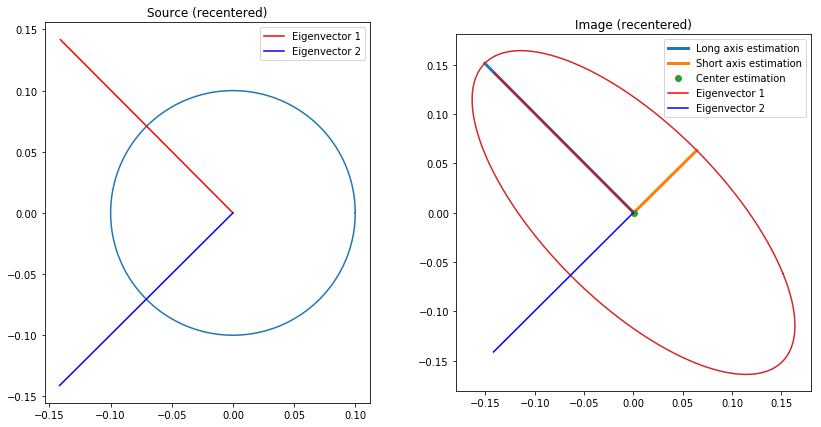

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.21309912526849756
 lambda2 = 0.9980039635224329
 1/lambda1 = 4.692651829236907
 1/lambda2 = 1.002000028607624
 gamma 0.39245241912696766
 kappa 0.3944484556045348
 g  0.648090856607031
 g1 0.11593401910809126
 g2 -0.637637092420979

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6505965659852794
 g1 0.11426749444278611
 g2 -0.640483279551938

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.5370508426917
 g1 0.26995984579102056
 g2 -1.5131579476973822



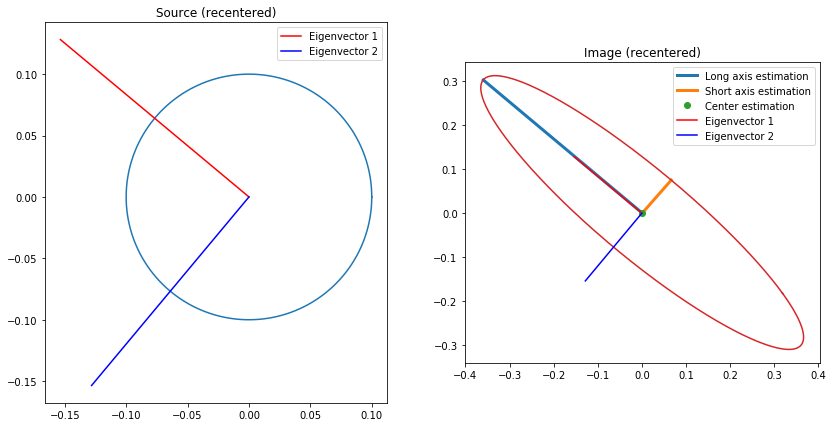

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.20210984896838957
 lambda2 = 1.0067394991902114
 1/lambda1 = 4.947804399954809
 1/lambda2 = 0.9933056175945888
 gamma 0.4023148251109109
 kappa 0.3955753259206995
 g  0.6656161509682631
 g1 0.5527850666451514
 g2 -0.3707742312026568

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6675379927937654
 g1 0.5535718958450748
 g2 -0.3730484257487474

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.498042075200577
 g1 1.2422873313229923
 g2 -0.8371691857119737



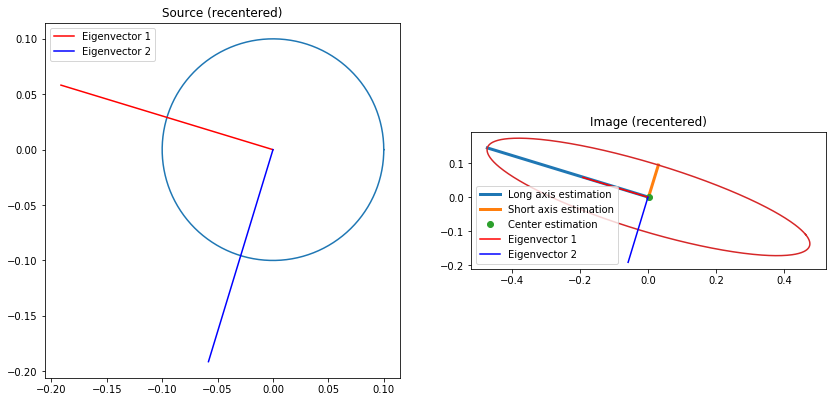

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.23716133138523304
 lambda2 = 1.0031475407277317
 1/lambda1 = 4.216538987022509
 1/lambda2 = 0.9968623352000162
 gamma 0.3829931046712493
 kappa 0.3798455639435177
 g  0.6175769814800891
 g1 0.5529697007917055
 g2 -0.2750015237419422

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6191816380510579
 g1 0.5536892686355657
 g2 -0.2771535579735602

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.615034972851601
 g1 1.4442087393833944
 g2 -0.7229101469908951



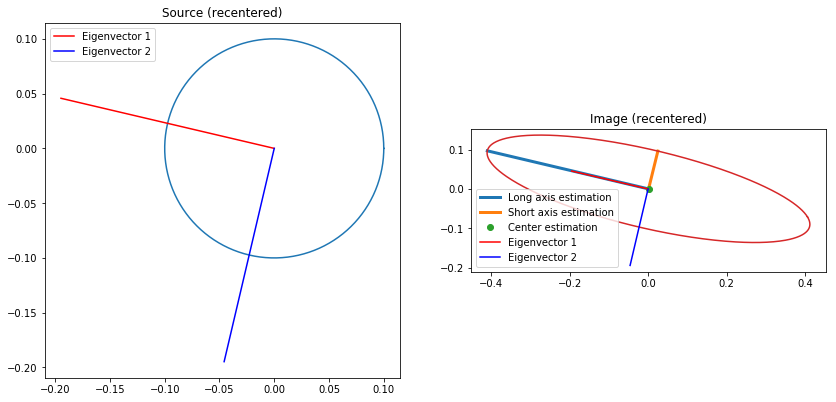

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.5106737874068735
 lambda2 = 1.1190282385824117
 1/lambda1 = 1.9581972379625223
 1/lambda2 = 0.8936324978418801
 gamma 0.30417722558776916
 kappa 0.18514898700535726
 g  0.3732918297173044
 g1 -0.08795796642897136
 g2 -0.3627811823611761

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.3747258204501857
 g1 -0.08659464035556487
 g2 -0.3645830615562868

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.66861781448267
 g1 -0.6166855532238407
 g2 -2.596385943618411



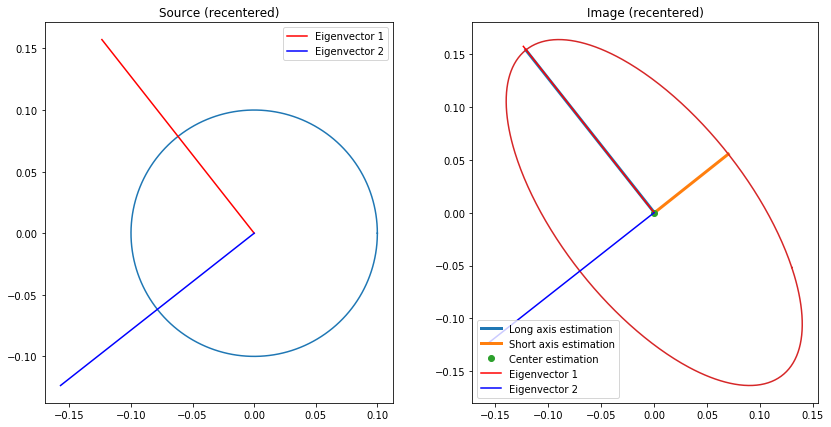

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.26413937923802305
 lambda2 = 1.0195517048077212
 1/lambda1 = 3.785880026237486
 1/lambda2 = 0.9808232336667924
 gamma 0.3777061627848491
 kappa 0.3581544579771279
 g  0.5884689353679262
 g1 0.41237315827321797
 g2 -0.41981432351556563

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5901689301695583
 g1 0.4131949356734148
 g2 -0.4213897379758121

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.694430101077492
 g1 1.1863212392706974
 g2 -1.2098492818085718



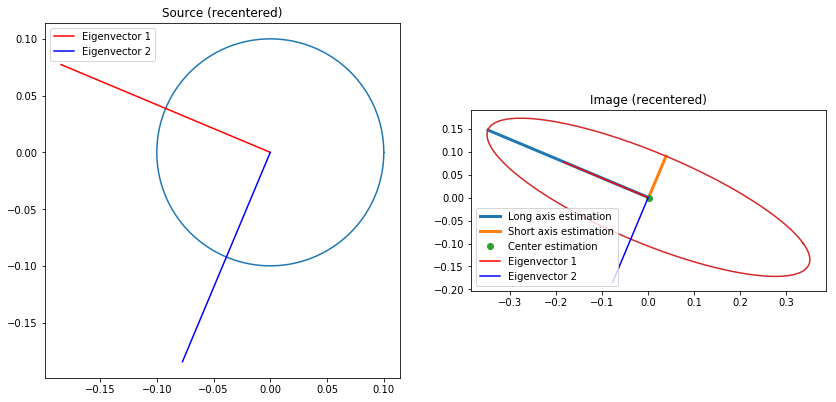

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -0.8306697887449963
 lambda2 = 0.7227084762377944
 1/lambda1 = -1.2038478027602681
 1/lambda2 = 1.3836837852043784
 gamma 0.7766891324913954
 kappa 1.053980656253601
 g  14.388286219465591
 g1 0.07565882036301139
 g2 -14.38808729735001

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.07108480506992207
 g1 -0.0007123802716400357
 g2 -0.07108123540131668

Estimate based on g = (1+b/a)/(1-b/a)
 g  14.067704047529666
 g1 -0.14098026745481235
 g2 -14.066997609051866



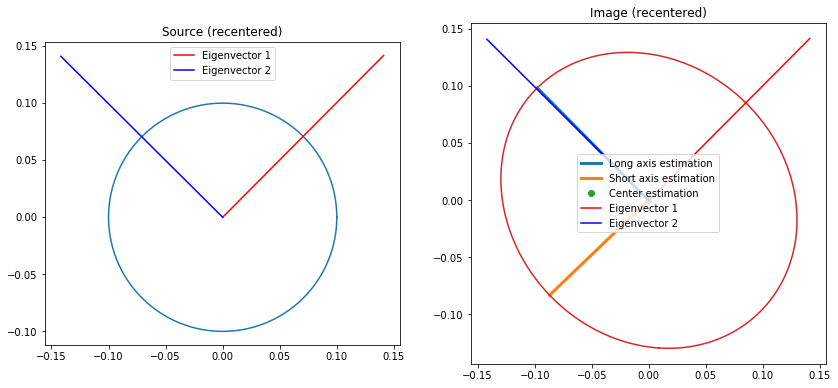

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.2664227911257832
 lambda2 = 1.0950460787231449
 1/lambda1 = 3.753432639056323
 1/lambda2 = 0.9132035805890731
 gamma 0.41431164379868085
 kappa 0.31926556507553594
 g  0.6086244834149662
 g1 -0.5599795542585009
 g2 -0.23842537747602505

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6107762850610481
 g1 -0.5632013523879797
 g2 -0.2363300807373563

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.637260686865156
 g1 -1.5097302492056683
 g2 -0.6335117452640898



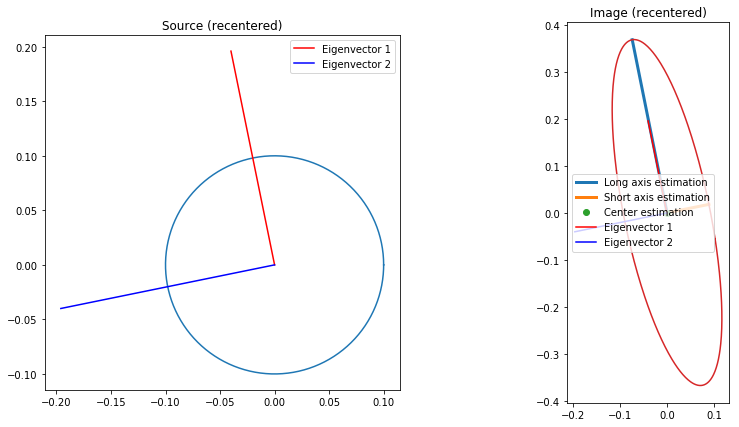

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.36626966879376555
 lambda2 = 1.0864392585925362
 1/lambda1 = 2.7302288046217313
 1/lambda2 = 0.9204380199731398
 gamma 0.3600847948993854
 kappa 0.27364553630684907
 g  0.4957425236550945
 g1 -0.07823343790252456
 g2 -0.4895305699891211

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.49739182519428604
 g1 -0.07775137177181836
 g2 -0.49127726586694775

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.010487405194869
 g1 -0.3142756791847259
 g2 -1.9857719919266101



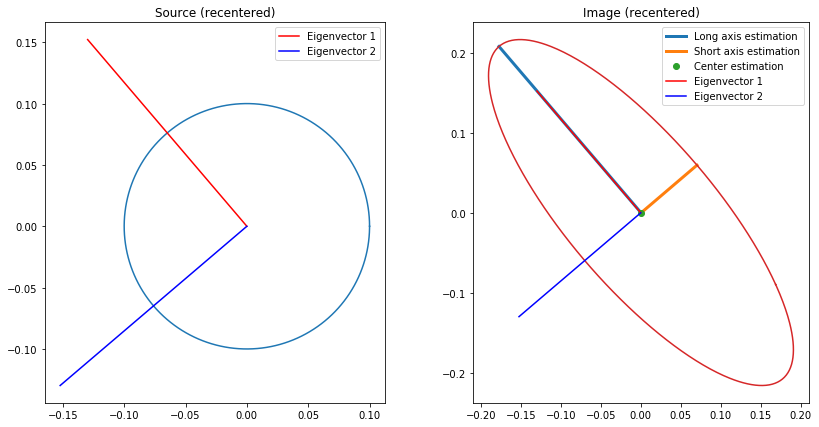

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.18616095233568458
 lambda2 = 1.092837967072482
 1/lambda1 = 5.3716957689215326
 1/lambda2 = 0.9150487356134064
 gamma 0.4533385073683987
 kappa 0.36050054029591677
 g  0.7088958410976185
 g1 -0.7039493789873132
 g2 0.08359775923358206

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.7119371844770028
 g1 -0.7067628648940842
 g2 0.08567851217048725

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.4046183031366895
 g1 -1.3944096159787274
 g2 0.16903964142369282



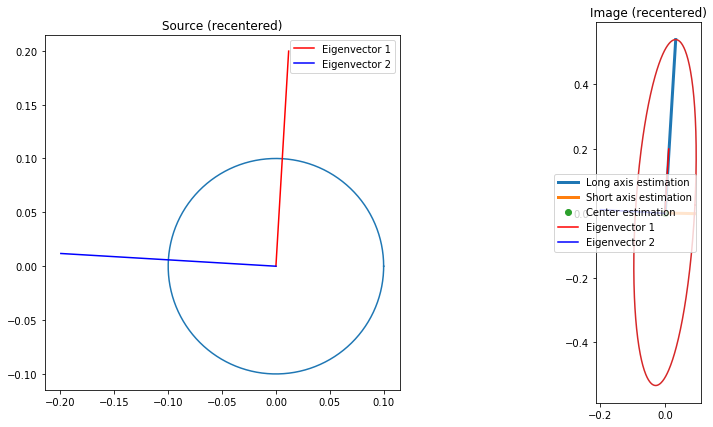

In [7]:
for i in range(10):
    print("-----------------------------------------------------------------------------------------------")
    plt.figure(figsize=(14,7))
    estimateReducedShearFromDeformedCircularSource()
    plt.show()

In [26]:
def estGFromEll(noiseLevel=0, simulateMeasurement = False):
    theta = np.random.uniform(-100*ANGLE_ARCSEC, 100*ANGLE_ARCSEC, 2)
    zs = 2
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 1)

    if not simulateMeasurement:
        g = gamma/(1-kappa)
        a = 1/(1-kappa-gamma)
        b = 1/(1-kappa+gamma)
    else:
        g = abs(gamma/(1-kappa))
        a = abs(1/(1-kappa-gamma))
        b = abs(1/(1-kappa+gamma))

    a *= np.random.normal(1, noiseLevel)
    b *= np.random.normal(1, noiseLevel)

    if simulateMeasurement:
        if a < b:
            a, b = b, a

    aOverB = a/b
    gEst = (aOverB-1)/(aOverB+1)
    return kappa, g, gEst, abs(g-gEst)

def plotNPHist(h, *args, **kwargs):
    counts, edges = h
    if False:
        binWidth = edges[1]-edges[0]
        center = (edges[:-1] + edges[1:])/2
        plt.bar(center, counts, *args, align='center', width=binWidth, **kwargs)
    else:
        y = np.array([counts,counts]).T.reshape((-1,))
        x = np.array([edges, edges]).T.reshape((-1,))[1:-1]
        plt.plot(x, y, *args, **kwargs)

def plotNoiseSensitivity(noiseLevel, numPts, gDiffThreshold, simulateMeasurement=False, *args, **kwargs):
    a = np.array([ estGFromEll(noiseLevel, simulateMeasurement=simulateMeasurement) for i in range(numPts) ])
    correctBelowThreshold = a[a[:,3] < gDiffThreshold][:,0]
    total = a[:,0]
    
    kappaRange = [0.1, 3]
    numBins = 100
    corrCount = np.histogram(correctBelowThreshold, bins=numBins, range=kappaRange)
    totalCount = np.histogram(total, bins=numBins, range=kappaRange)
    frac = corrCount[0]/totalCount[0], corrCount[1]
    plotNPHist(frac, *args, **kwargs)
    plt.gca().set_xlim(kappaRange)


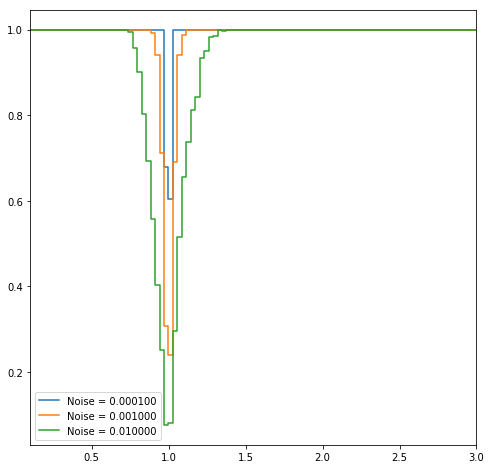

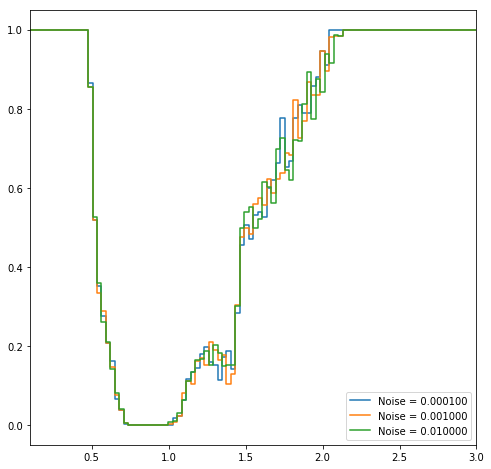

In [28]:
numPoints = 100000
gErrorTolerance = 0.1
baseNoise = 0.0001
for simulateMeasurement in [ False, True]:
    plt.figure(figsize=(8,8))
    for i in range(3):
        noise = baseNoise*10**i
        plotNoiseSensitivity(noise, numPoints, gErrorTolerance, simulateMeasurement, label =f"Noise = {noise:05f}")
    plt.legend()

In [6]:
# Derivations for these formulas can be found at
# https://nbviewer.jupyter.org/url/research.edm.uhasselt.be/~jori/grale2/_static/ellipsetransform.ipynb

def getTransFormedEllipseParams(a, b, theta, kappa, gamma1, gamma2):
    
    A = 1-kappa-gamma1
    B = -gamma2
    C = 1-kappa+gamma1
    
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    
    C_x = (A*sin(theta) + B*cos(theta))**2/b**2 + (A*cos(theta) - B*sin(theta))**2/a**2
    C_y = (B*sin(theta) + C*cos(theta))**2/b**2 + (B*cos(theta) - C*sin(theta))**2/a**2
    C_xy = 2*(a**2*(A*sin(theta) + B*cos(theta))*(B*sin(theta) + C*cos(theta)) + b**2*(A*cos(theta) - B*sin(theta))*(B*cos(theta) - C*sin(theta)))/(a**2*b**2)
    
    a_new = sqrt(2/((C_x+C_y)-sqrt(C_xy**2+(C_x-C_y)**2)))
    b_new = sqrt(2/((C_x+C_y)+sqrt(C_xy**2+(C_x-C_y)**2)))
    
    #cosTwoTheta_new = -(C_x-C_y)*(a_new**2*b_new**2)/(a_new**2-b_new**2)
    cosTwoTheta_new = -(C_x-C_y)*(b_new**2)/(1-(b_new/a_new)**2)
    sinTwoTheta_new = C_xy*(C_x+C_y)/(1/b_new**4-1/a_new**4)
    theta_new = 0.5*np.arctan2(sinTwoTheta_new, cosTwoTheta_new)
    
    return a_new, b_new, theta_new
    

In [7]:
def plotEllipse(a, b, theta):
    angles = np.linspace(0, np.pi*2, 20)
    x = a*np.cos(angles)
    y = b*np.sin(angles)
    xy = np.array([x,y])
    rotAngle = theta
    rotMatrix = np.array([[ np.cos(rotAngle), np.sin(rotAngle)],[-np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy).T
    plt.plot(xyRot[:,0], xyRot[:,1], 'o')

In [4]:
def generateBetaEllipseAndTrace(beta, betaRadius, betaE, betaAngle, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))

    x = betaRadius*np.cos(angles)
    y = betaRadius*betaE*np.sin(angles)
    xy = np.array([x,y])
    
    rotAngle = betaAngle
    rotMatrix = np.array([[ np.cos(rotAngle), np.sin(rotAngle)],[-np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy)
    betas[:,0] = xyRot[0,:] + beta[0]
    betas[:,1] = xyRot[1,:] + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

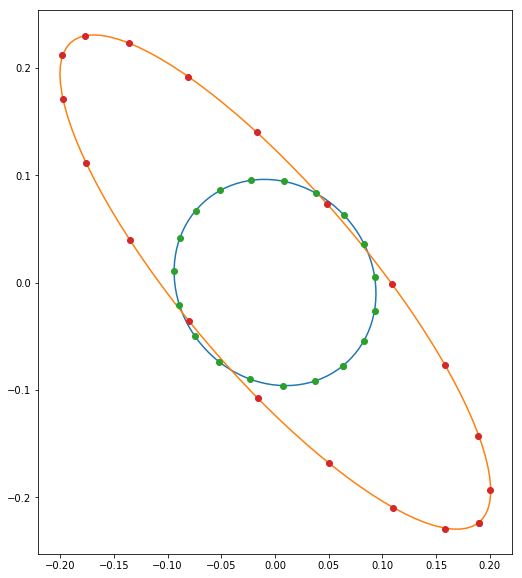

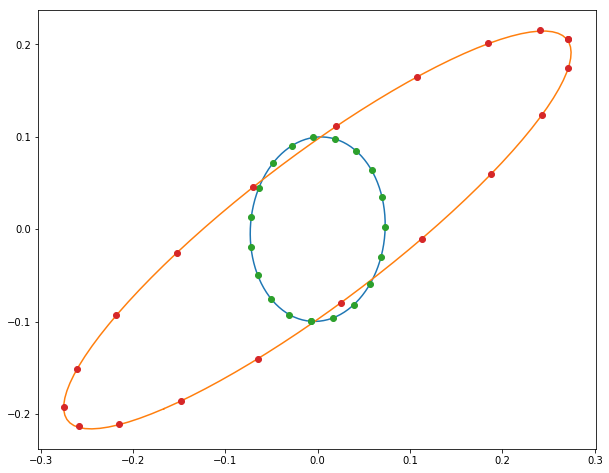

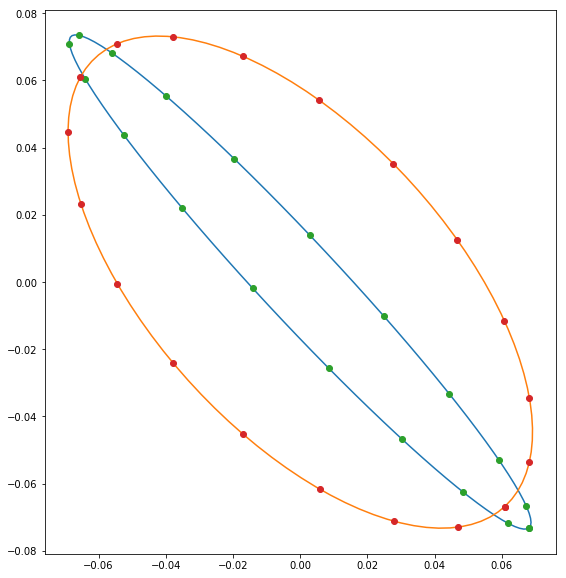

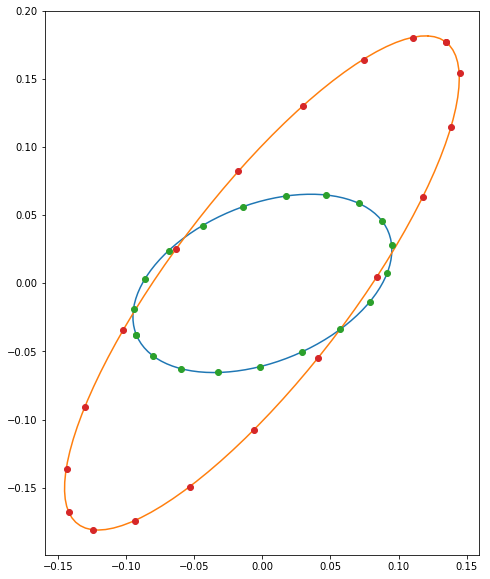

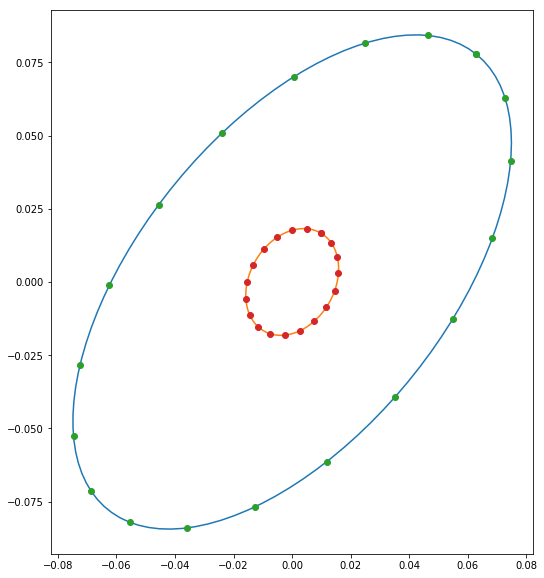

In [8]:
def getTransFormedRandomEllipseParams(plot=False, beta=None, theta=None, zs=None, betaE=None):
    beta, theta, zs = pickBetaTheta(beta, theta, zs)
    #print(beta, theta, zs)
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
    
    betaRadius = 0.1
    betaE = np.random.uniform(0.1,0.9) if betaE is None else betaE
    betaAngle = np.random.uniform(0,2*np.pi)
    
    if plot:
        betas, thetas = generateBetaEllipseAndTrace(beta, betaRadius*ANGLE_ARCSEC, betaE, betaAngle, 100)
        betas = (betas-beta)/ANGLE_ARCSEC
        thetas = (thetas-theta)/ANGLE_ARCSEC

        #plt.figure(figsize=(10,10))
        plt.plot(betas[:,0],betas[:,1])
        plt.plot(thetas[:,0],thetas[:,1])
        plt.gca().set_aspect("equal")

    a_new, b_new, theta_new = getTransFormedEllipseParams(betaRadius, betaRadius*betaE, betaAngle, kappa, gamma1, gamma2)
    if plot:    
        plotEllipse(betaRadius, betaRadius*betaE, betaAngle)
        plotEllipse(a_new, b_new, theta_new)

    return betaRadius, betaRadius*betaE, betaAngle, a_new, b_new, theta_new

for i in range(5):
    plt.figure(figsize=(10,10))
    getTransFormedRandomEllipseParams(True)

In [24]:
def getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, num, betaE=None, noiseLevel=0):
    while True:
        beta, theta, zs = pickBetaTheta()
        kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
        if kappaThresholdFunction(kappa): 
            break

    g1Ests = [ ]
    g2Ests = [ ]
    for i in range(num):
        a_orig, b_orig, theta_orig, a_new, b_new, theta_new = getTransFormedRandomEllipseParams(False, beta, theta, zs,
                                                                                                betaE=betaE)
        theta_new = -theta_new # Apparently I used a different angle orientation here
        a_new *= np.random.normal(1, noiseLevel)
        b_new *= np.random.normal(1, noiseLevel)

        aOverB = a_new/b_new
        gEst = (aOverB-1)/(aOverB+1)
        g1Est = gEst*np.cos(2*theta_new)
        g2Est = gEst*np.sin(2*theta_new)

        g1Ests.append(g1Est)
        g2Ests.append(g2Est)

    return kappa, gamma1, gamma2, g1Ests, g2Ests

kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(lambda kappa: abs(1-kappa) > 0.5, 
                                                                             50, betaE=None, noiseLevel=0.01)
print("kappa =", kappa)
print("g1,real = ", gamma1/(1-kappa))
print("g2,real = ", gamma2/(1-kappa))
print("g1Est,mean =", np.mean(g1Ests))
print("g2Est,mean =", np.mean(g2Ests))

kappa = 0.3632332895989485
g1,real =  -0.2277621415771403
g2,real =  0.7110582397651407
g1Est,mean = -0.2224769590542559
g2Est,mean = 0.6934874264723321


In [44]:
def getEstimatedShearDeviations(kappaThresholdFunction, numEllipses, numRepeats, noiseLevel=0):
    g1Diffs, g2Diffs = [], []
    for i in range(numRepeats):
        kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, 
                                                                             numEllipses, 
                                                                             betaE=None, noiseLevel=noiseLevel)
        g1Est, g2Est = np.mean(g1Ests), np.mean(g2Ests)
        g1Diffs.append(gamma1/(1-kappa) - g1Est)
        g2Diffs.append(gamma2/(1-kappa) - g2Est)
    
    return g1Diffs, g2Diffs

In [63]:
numEllipses = [ 1, 5, 10, 25, 50, 100, 200 ]
precisions = [ ]
for n in numEllipses:
    p = np.std(g1Diffs+g2Diffs)
    precisions.append(p)
    print(n, p)    

1 0.2353622251985153
5 0.11527298745307345
10 0.08706137191998924
25 0.05946975673619648
50 0.06455144692570643
100 0.07738349123259894
200 0.0632429223484918


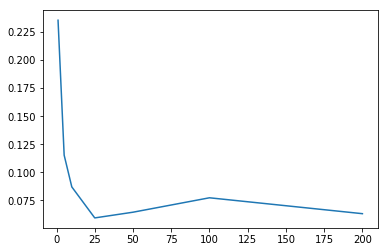

In [64]:
plt.plot(numEllipses, precisions)

In [8]:
def plotVectors(vectors, angularScale=1, lengthFactor=1, **kwargs):
    
    xCoords, yCoords = [], []
    for cx, cy, vx, vy in vectors:
        length = (vx**2+vy**2)**0.5
        phi = np.arctan2(vy, vx)
        
        xCoords.append((cx/angularScale - length*lengthFactor*np.cos(phi)))
        xCoords.append((cx/angularScale + length*lengthFactor*np.cos(phi)))
        xCoords.append(None)
        yCoords.append((cy/angularScale - length*lengthFactor*np.sin(phi)))
        yCoords.append((cy/angularScale + length*lengthFactor*np.sin(phi)))
        yCoords.append(None)
        
    plt.plot(xCoords, yCoords, '-', **kwargs)
    plt.gca().set_xlim([vectors[:,0].min()/angularScale, vectors[:,0].max()/angularScale])
    plt.gca().set_ylim([vectors[:,1].min()/angularScale, vectors[:,1].max()/angularScale])


def plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=1, plotType="real", **kwargs):
    thetas = thetas.reshape((-1,2))
    kappa = kappa.reshape((-1,))
    gamma1 = gamma1.reshape((-1,))
    gamma2 = gamma2.reshape((-1,))
    gamma = (gamma1**2+gamma2**2)**0.5
    
    if plotType == "real":
        lengths = gamma
        angles = 0.5*np.arctan2(gamma2, gamma1)
    elif plotType == "realreduced":
        lengths = gamma/(1-kappa)
        angles = 0.5*np.arctan2(gamma2, gamma1)
    elif plotType == "measuredreduced":
        l1 = 1/(1-kappa-gamma)
        l2 = 1/(1-kappa+gamma)
        v1 = np.array([ gamma2, gamma-gamma1 ]).T
        v2 = np.array([ gamma1-gamma, gamma2 ]).T
        
        b = np.abs(l2.copy())
        a = np.abs(l1.copy())
        v = v1.copy()
        flag = a < b
        a[flag] = np.abs(l2[flag])
        b[flag] = np.abs(l1[flag])
        v[flag] = v2[flag]
        
        e = b/a
        g = (1-e)/(1+e)
        
        lengths = g
        angles = np.arctan2(v[:,1], v[:,0])
    else:
        raise Exception(f"Unknown plotType '{plotType}'")
        
    angles[angles < 0] += 2.0*np.pi
    angles[angles > np.pi] -= np.pi
    
    vectors = [ ]
    for i in range(len(thetas)):
        cx = thetas[i,0]
        cy = thetas[i,1]
        length = lengths[i]
        phi = angles[i]
        
        vectors.append([cx,cy, length*np.cos(phi), length*np.sin(phi)])
        
    vectors = np.array(vectors)
    plotVectors(vectors, angularScale=angularScale, lengthFactor=lengthFactor, **kwargs)
    return np.array(vectors)


In [9]:
def createThetas(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [14]:
zs = 1
Ds = cosm.getAngularDiameterDistance(zs)
Dds = cosm.getAngularDiameterDistance(z_lens, zs)
strongSize = 200*ANGLE_ARCSEC
thetas = createThetas([-strongSize/2, -strongSize/2],[strongSize/2, strongSize/2], 48,48)
a = lens.getAlphaVectorDerivatives(thetas)
a *= Dds/Ds
axx, ayy, axy = a[:,:,0], a[:,:,1], a[:,:,2]
kappa = 0.5*(axx+ayy)
gamma1 = 0.5*(axx-ayy)
gamma2 = axy

In [18]:
sources = [ ]
for pos in thetas.reshape((-1,2)):
    sources.append(images.CircularSource(pos, 0.2*ANGLE_ARCSEC))

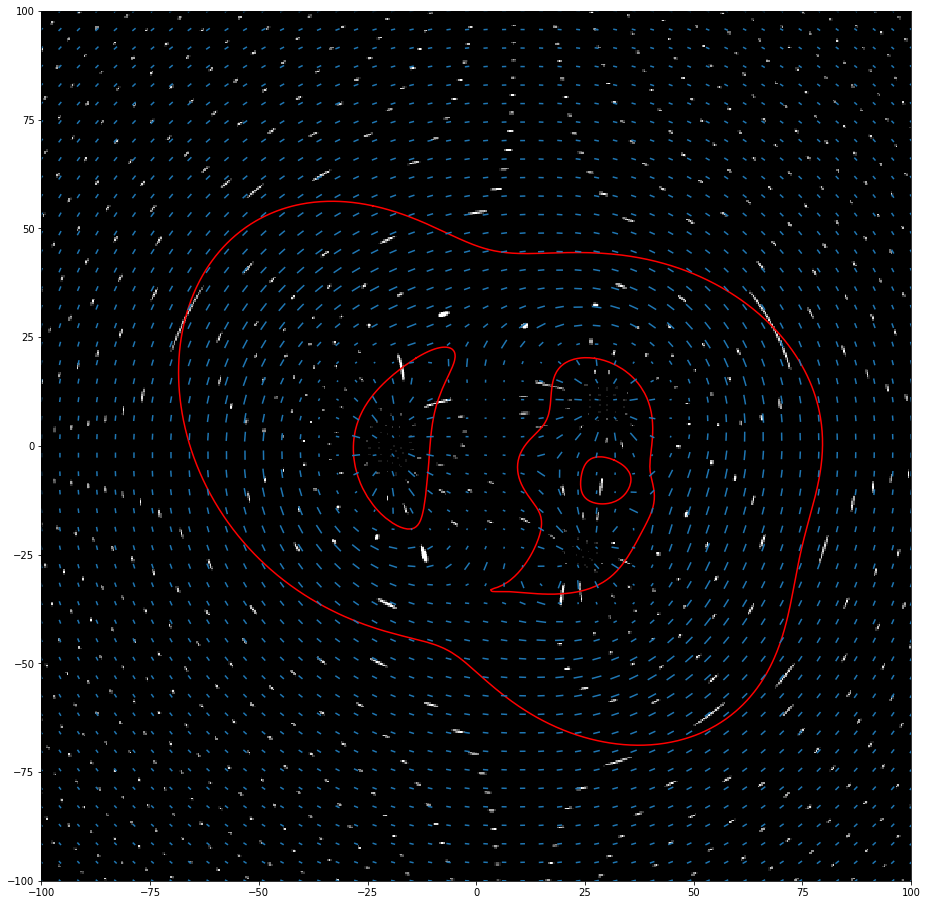

In [22]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vMR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="measuredreduced")

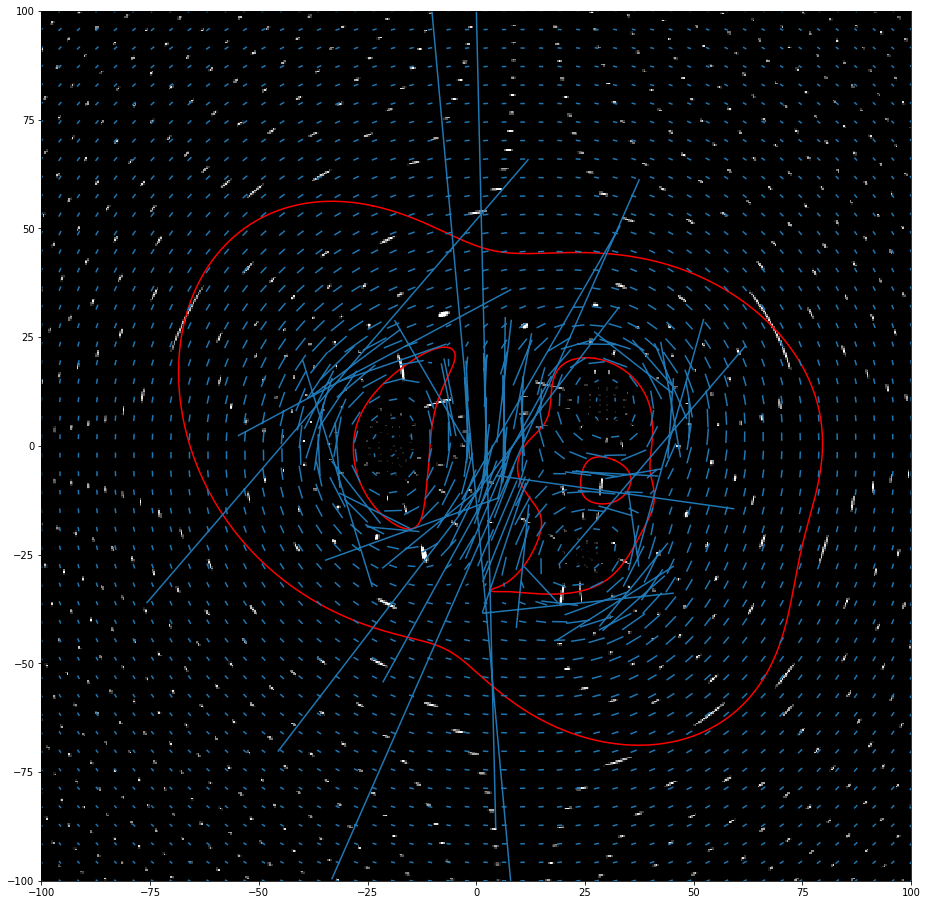

In [23]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vRR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="realreduced")

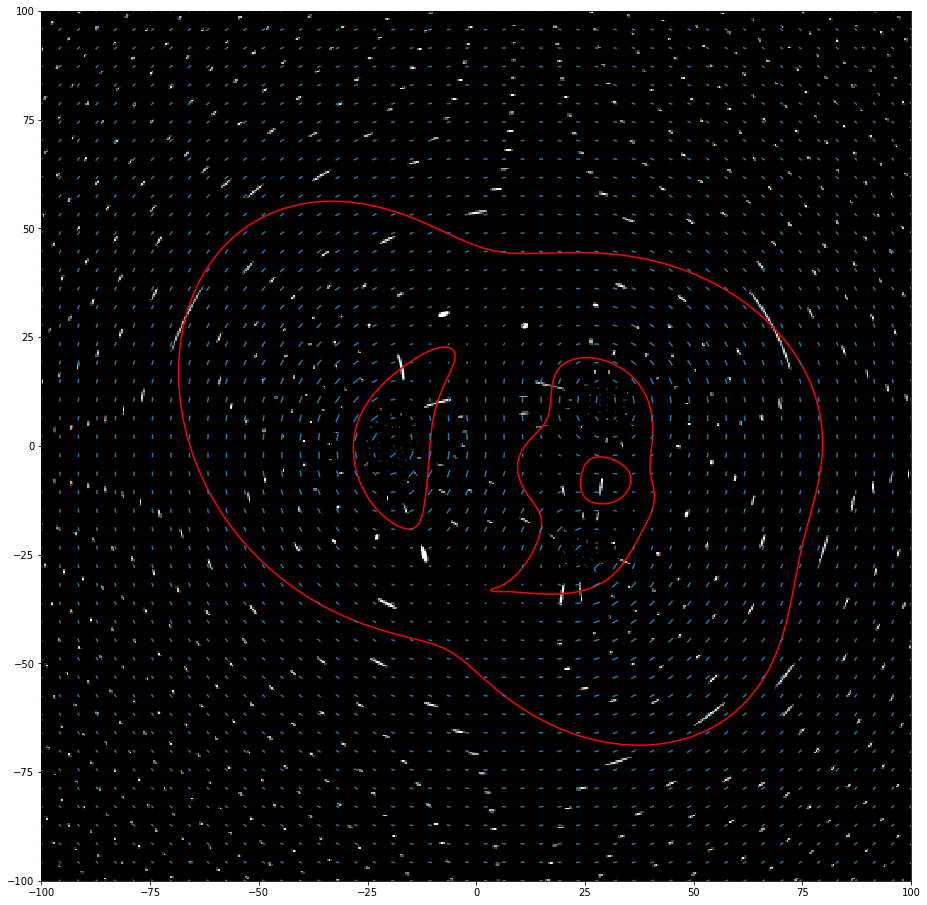

In [24]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="real")